C:\Users\User\OneDrive - aueb.gr\Επιφάνεια εργασίας\Msc\Machine Learning\Project2020-21P


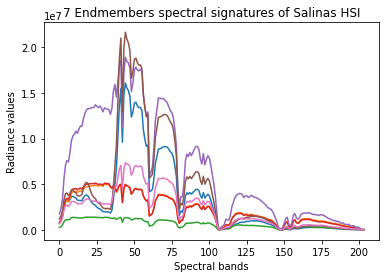

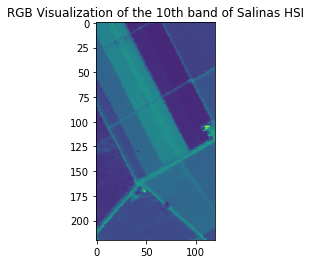

In [25]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
import os
from scipy.optimize import nnls 
from scipy.optimize import least_squares
from scipy.optimize import minimize
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
path = r"C:\Users\User\OneDrive - aueb.gr\Επιφάνεια εργασίας\Msc\Machine Learning\Project2020-21P"   ###Insert the path here
dirs = os.listdir( path )
os.chdir(path)
print(os.getcwd())

Salinas = sio.loadmat('Salinas_cube.mat')
HSI= Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
endmembers = ends['salinas_endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Salinas HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

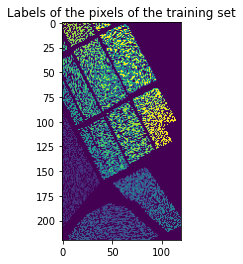

In [2]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

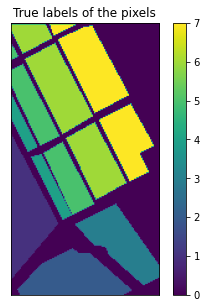

In [8]:
fig = plt.figure(figsize = (5,5))
plt.imshow(labels)
plt.title('True labels of the pixels')
plt.colorbar()
plt.xticks(())
plt.yticks(())
plt.show()

In [4]:
#for the iterations of 3D ARRAY
PicX=HSI.shape[0]
PicY=HSI.shape[1]
PicL=HSI.shape[2]

a) LS

In [169]:
Xa=endmembers
thetaF=np.zeros((PicX,PicY,7))

for i in range(PicX):
    for j in range(PicY):
        Ya=HSI[i,j,:]
        if labels[i][j]!=0:
            XTX_IN = np.linalg.inv(np.dot(Xa.T,Xa))
            XTY=Xa.T.dot(Ya.T)
            thetaF[i,j]=XTX_IN.dot(XTY)    

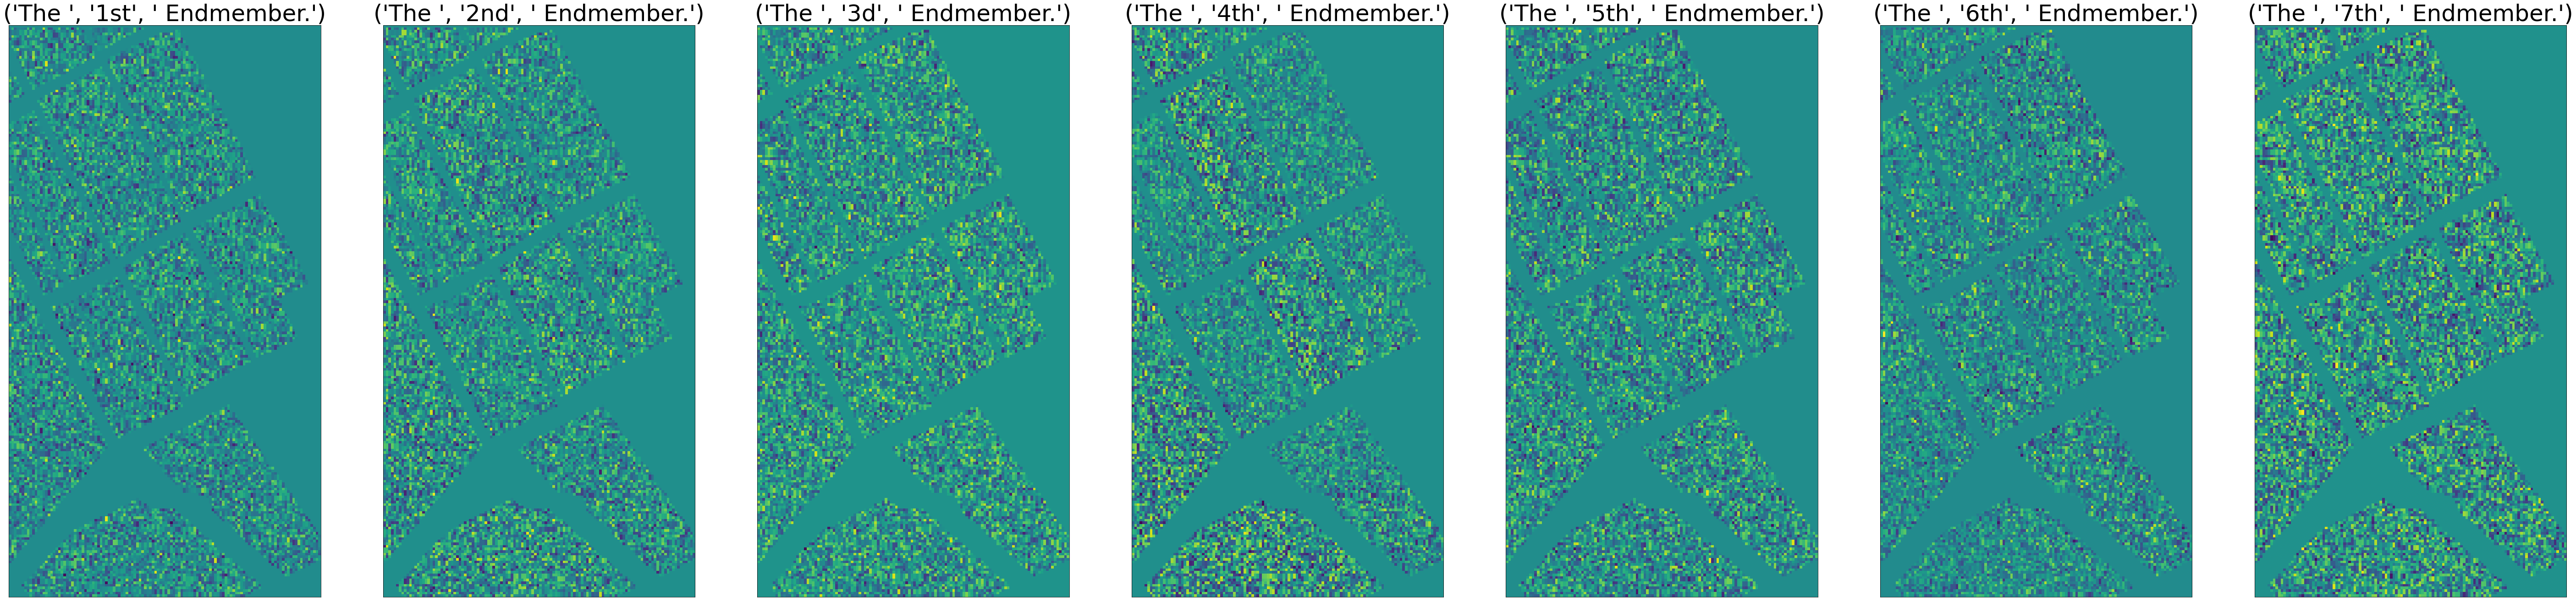

In [170]:
counts=["1st","2nd","3d","4th","5th","6th","7th"]
fig = plt.figure(figsize=(100,100))
for L in range(7):
    plt.subplot(1,7,L+1)   
    theta_material =thetaF[:,:,L]
    plt.imshow(theta_material)
    title = ("The ",counts[L]," Endmember.")
    plt.title(title,size=50)
    plt.xticks(())
    plt.yticks(())
plt.show()    
plt.close()    

In [171]:
ErrLS = np.empty((0))    
for i in range(PicX):
    for j in range(PicY):
        if labels[i,j]!=0:
            LS = Xa.dot(thetaF[i,j,:].T)    #θτΧ
            LS=LS.T
            ErrLS = np.append(ErrLS, [np.linalg.norm(HSI -LS)**2])  # 1x7 : HSI   ,7*1 : y_LS
            
final_err= np.mean(ErrLS)
print(final_err)

3.820801505281555e+20


B) counstraint sum to 1

In [172]:
thetaS= np.zeros((PicX,PicY,7))
Xb=Xa
Yb=HSI[0,3,:]

def func_B(thetaS,Xb,Yb):            
    AX=np.dot(Xb,thetaS)
    return np.linalg.norm(AX - Yb)
Xb_1=nnls(Xb,Yb)    #initializing     reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.nnls.html

#constrains from documentation for equality constraint Σx=1
c = ({'type': 'eq', 'fun': lambda x:  1-np.sum(x)}) # constrain of equality

In [173]:
for i in range(PicX):
    for j in range(PicY):
        if labels[i][j]!=0:
            thetaS[i,j]= minimize(  func_B,x0= Xb_1[0],args=(Xb ,HSI[i,j,:]) ,
                                  method='SLSQP',bounds=None,constraints =c).x  #reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html     

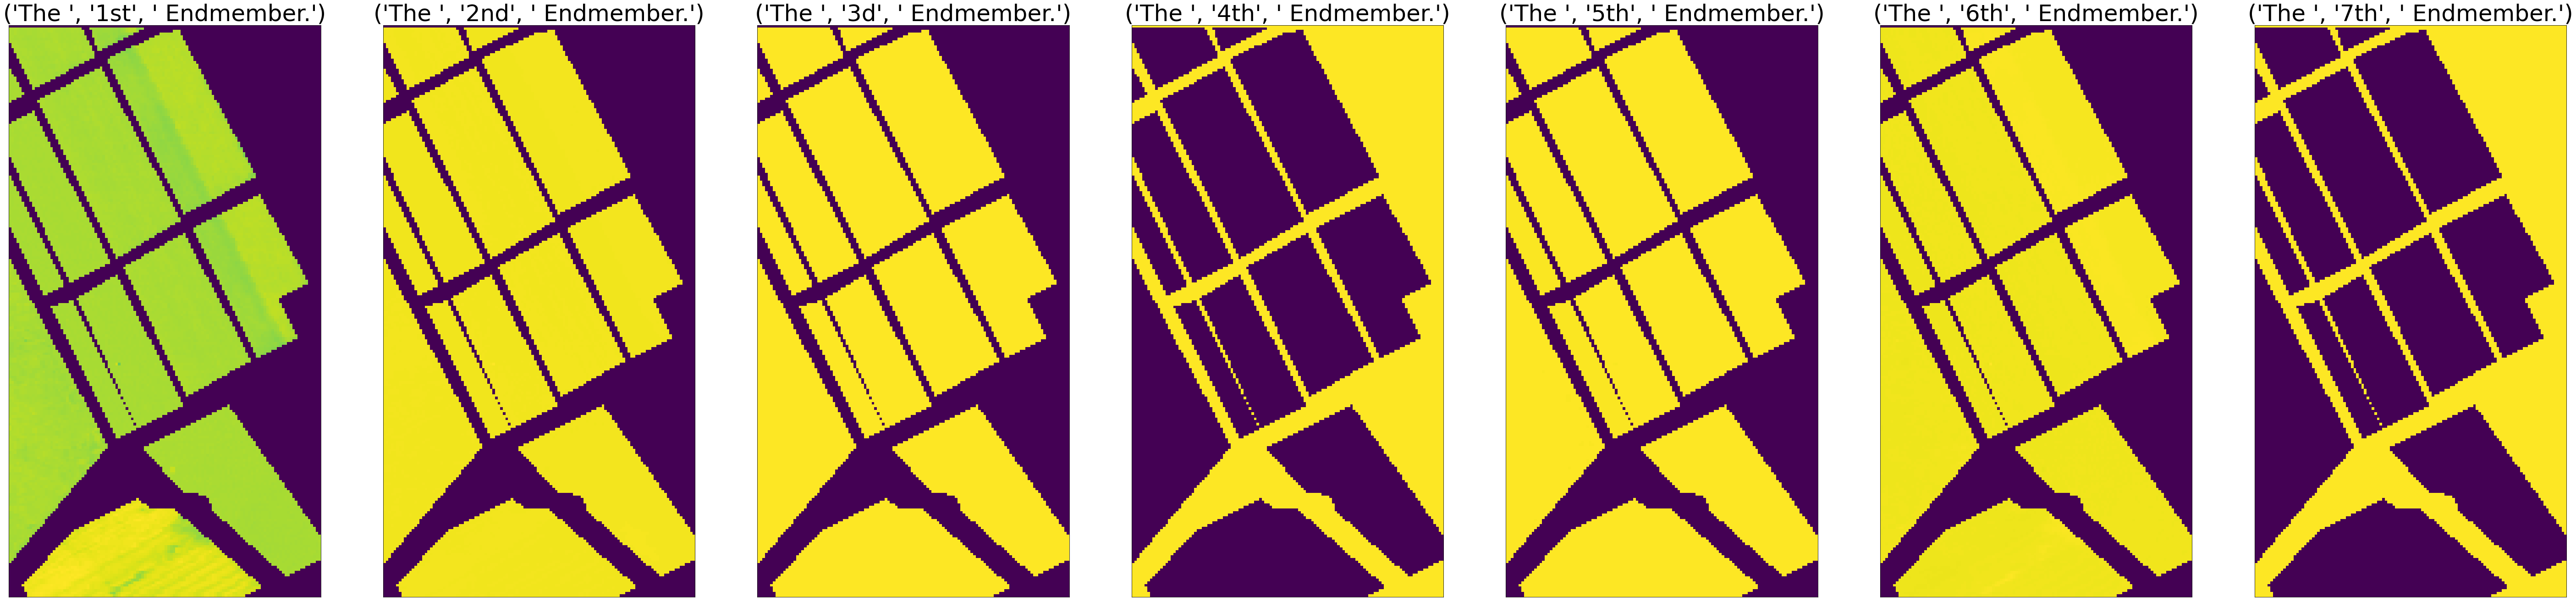

In [174]:
counts=["1st","2nd","3d","4th","5th","6th","7th"]
fig = plt.figure(figsize=(100,100))
for L in range(7):
    plt.subplot(1,7,L+1)   
    theta_material =thetaS[:,:,L]
    plt.imshow(theta_material)
    title = ("The ",counts[L]," Endmember.")
    plt.xticks(())
    plt.yticks(())
    plt.title(title,size=50)
plt.show()    
plt.close()    

In [59]:
ErrLSB = np.empty((0))    
for i in range(PicX):
    for j in range(PicY):
        if labels[i,j]!=0:
            yLSB = Xb.dot(thetaS[i,j,:].T)   #θτΧ
            yLSB=yLSB.T
            ErrLSB = np.append(ErrLSB, [np.linalg.norm( HSI - yLSB)**2]) # 1x7 : HSI   ,7*1 : y_LSB            
final_errB= np.mean(ErrLSB)
print(final_errB)

736337061527053.1


c) non-negativity constraint 


In [175]:
thetaT= np.zeros((PicX,PicY,7))
Xc=Xb
Yc=HSI[0,3,:]
Xc_1=nnls(Xc,Yc)    #initializing

In [178]:
for i in range(PicX):
    for j in range(PicY):
        if labels[i,j]!=0:
            Xc_1 = nnls(Xc,HSI[i,j,:])
            thetaT[i,j] = Xc_1[0]

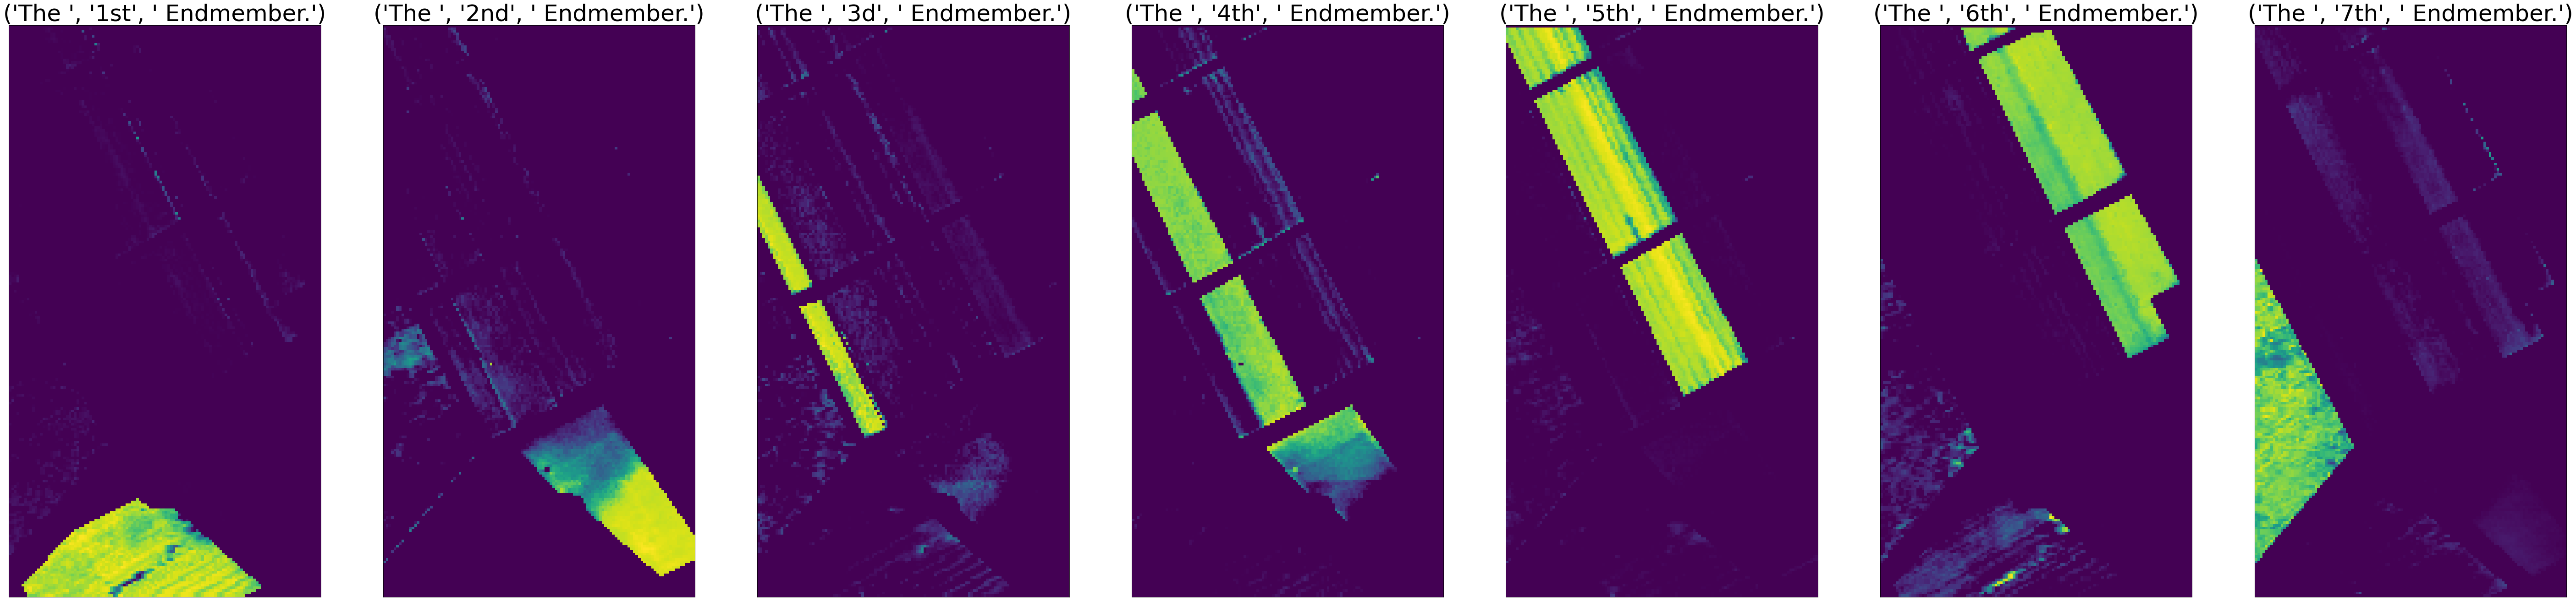

In [179]:
counts=["1st","2nd","3d","4th","5th","6th","7th"]
fig = plt.figure(figsize=(100,100))
for L in range(7):
    plt.subplot(1,7,L+1)   
    theta_material =thetaT[:,:,L]
    plt.imshow(theta_material)
    title = ("The ",counts[L]," Endmember.")
    plt.title(title,size=50)
    plt.xticks(())
    plt.yticks(())
plt.show()    
plt.close()    

In [180]:
ErrLST=np.empty((0))    
for i in range(PicX):
    for j in range(PicY):
        if labels[i,j]!=0:
            yLST = Xb.dot(thetaT[i,j,:].T)   #θτΧ 
            yLST=yLST.T
            ErrLST = np.append(ErrLST, [np.linalg.norm(HSI - yLST)**2])  # 1x7 : HSI   ,7*1 : y_LST            
final_errT= np.mean(ErrLST)
print(final_errT)

4413317986671.051


d) non-negativity + sum-to-one

In [181]:
Boundtuple =[]
for i in range(7):
    Boundtuple.append((0.0,1.12323**5000))

In [182]:
Boundtuple

[(0.0, 2.205321355304082e+252),
 (0.0, 2.205321355304082e+252),
 (0.0, 2.205321355304082e+252),
 (0.0, 2.205321355304082e+252),
 (0.0, 2.205321355304082e+252),
 (0.0, 2.205321355304082e+252),
 (0.0, 2.205321355304082e+252)]

In [183]:
thetaF = np.zeros((PicX,PicY,7))
F_nnls= nnls(Xa,HSI[3,0,:]) #initialize
for i in range(PicX):
    for j in range(PicY):
        if labels[i][j]!=0:
            thetaF[i,j] = minimize(func_B,x0=F_nnls[0], args = (Xb,HSI[i,j,:]), method = 'SLSQP',
                                   bounds = Boundtuple,constraints = c,).x

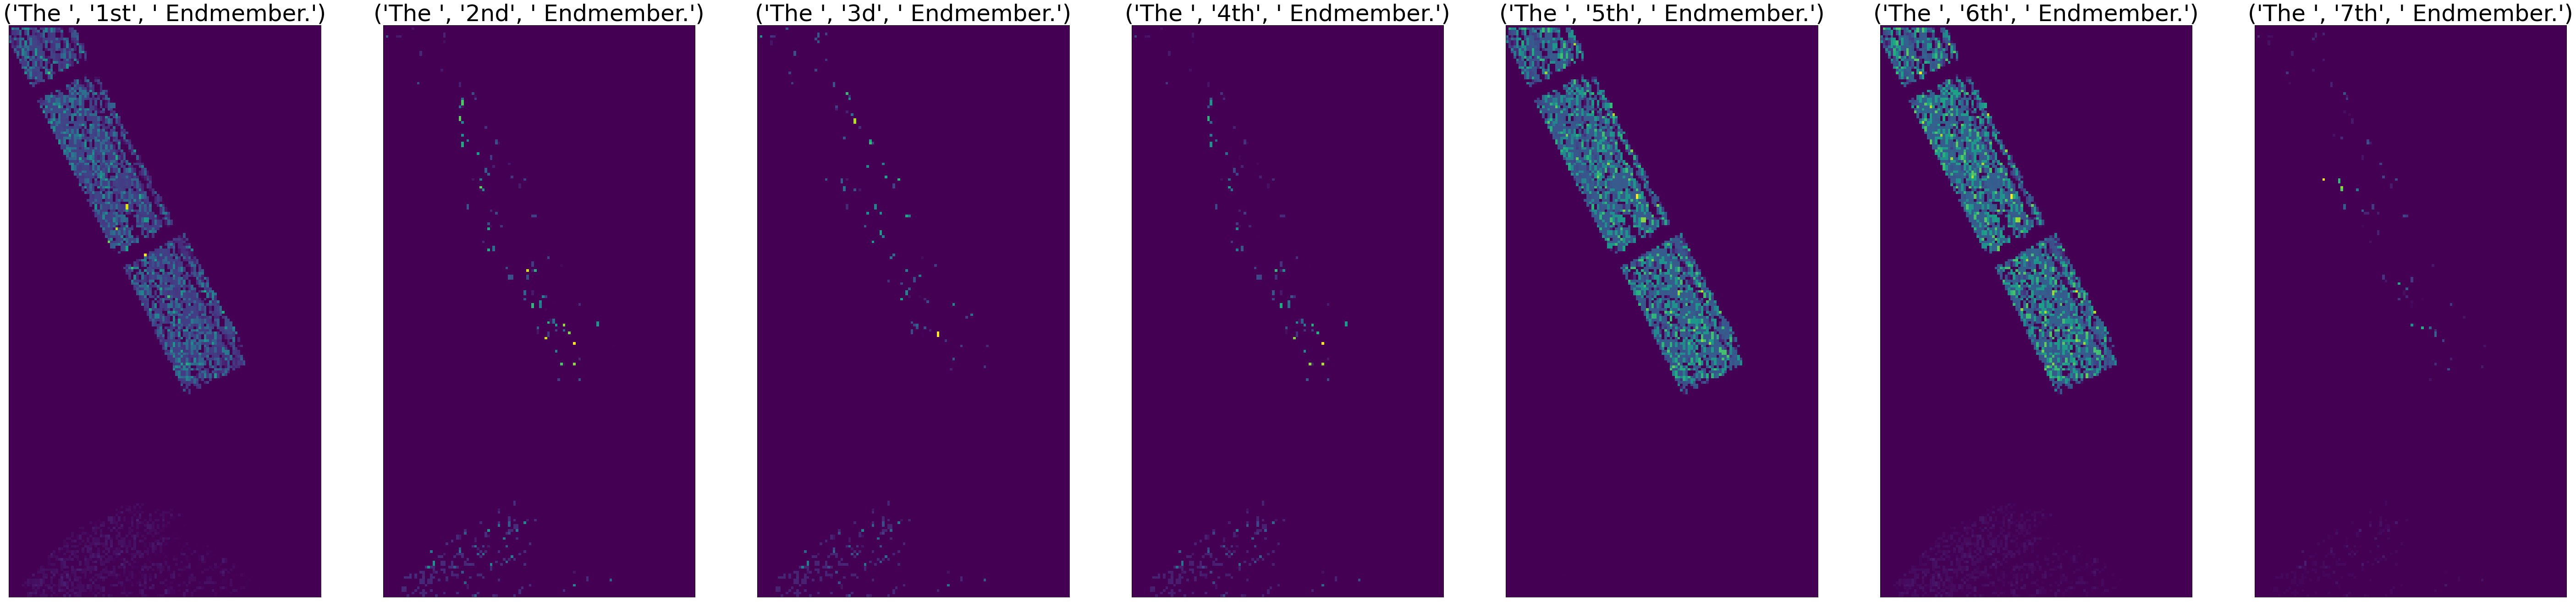

In [184]:
counts=["1st","2nd","3d","4th","5th","6th","7th"]
fig = plt.figure(figsize=(100,100))
for L in range(7):
    plt.subplot(1,7,L+1)   
    theta_material =thetaF[:,:,L]
    plt.imshow(theta_material)
    title = ("The ",counts[L]," Endmember.")
    plt.title(title,size=50)
    plt.xticks(())
    plt.yticks(())
plt.show()    
plt.close()   

In [185]:
ErrLSF= np.empty((0))    
for i in range(PicX):
    for j in range(PicY):
        if labels[i,j]!=0:
            yLSF = Xb.dot(thetaF[i,j,:].T)   #θτΧ 
            yLSF=yLSF.T
            ErrLSF=np.append(ErrLSF,[np.linalg.norm(HSI - yLSF)**2])  # 1x7 : HSI   ,7*1 : y_LST            
final_errF= np.mean(ErrLSF)
print(final_errF)

3.077341192326592e+20


Ε) Lasso to remove non important params.

In [186]:
thetaFth= np.zeros((PicX,PicY,7))
for i in range(PicX):
    for j in range(PicY):
        if labels[i][j]!=0: 
            Las = Lasso(warm_start=True,tol=1e-2,positive=True,selection='random')
            Las.fit(Xa,HSI[i,j,:])
            thetaFth[i,j,:]=Las.coef_

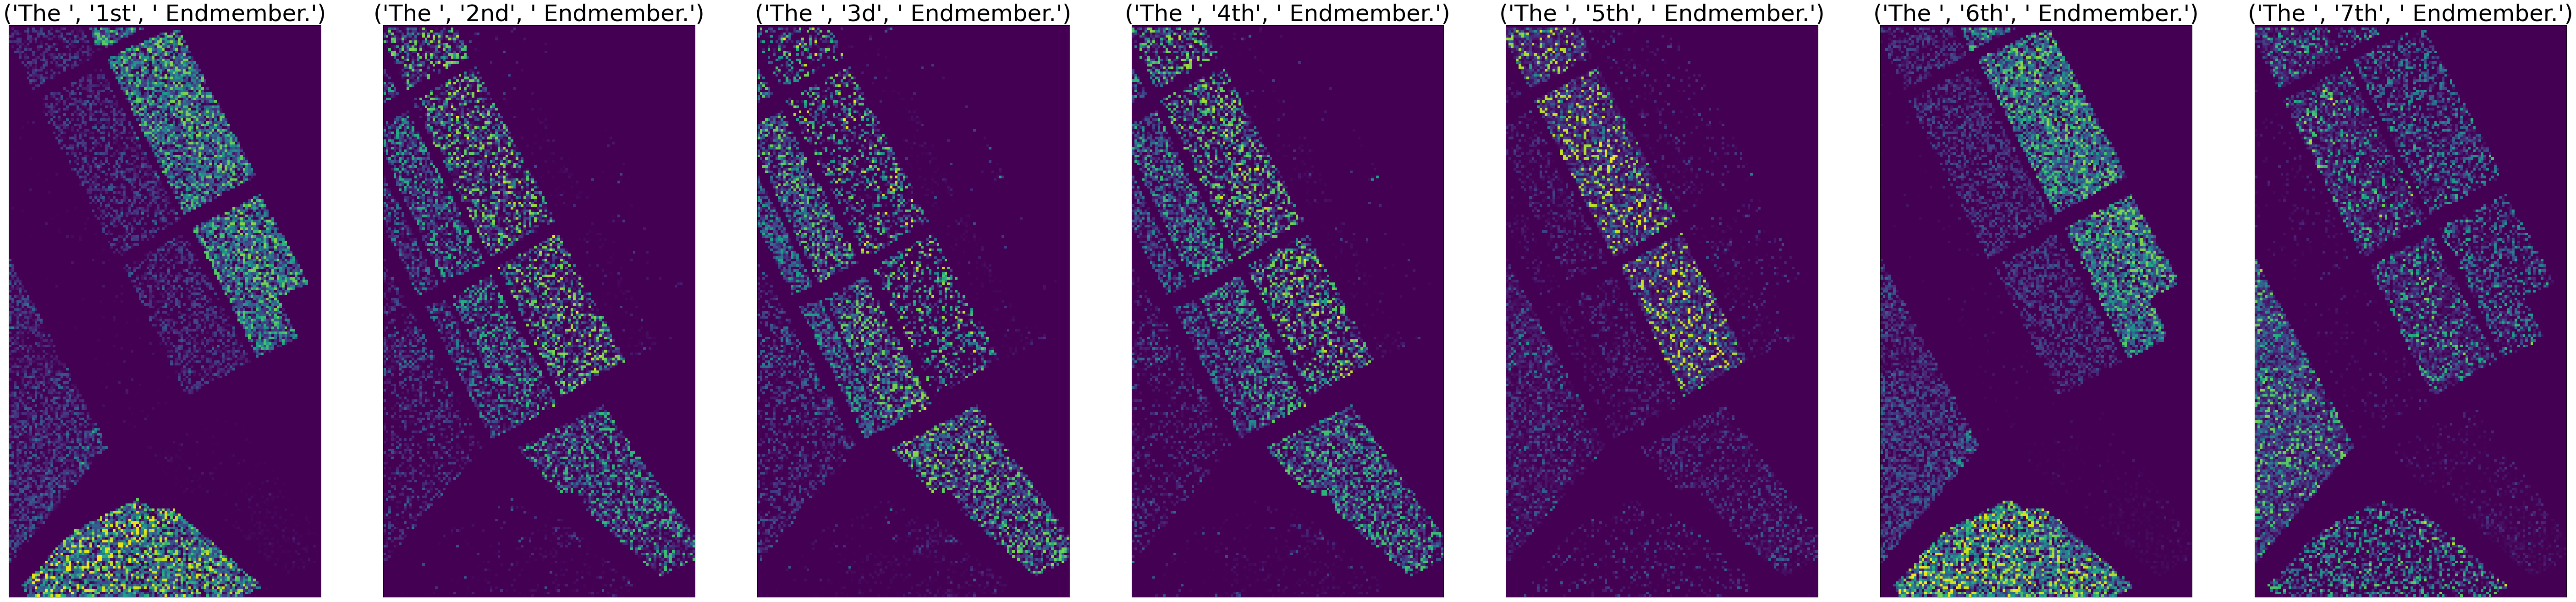

In [187]:
counts=["1st","2nd","3d","4th","5th","6th","7th"]
fig = plt.figure(figsize=(100,100))
for L in range(7):
    plt.subplot(1,7,L+1)   
    theta_material =thetaFth[:,:,L]
    plt.imshow(theta_material)
    title = ("The ",counts[L]," Endmember.")
    plt.title(title,size=50)
    plt.xticks(())
    plt.yticks(())
plt.show()    
plt.close()   

In [195]:
ErrLSFth = np.empty((0))    
for i in range(PicX):
    for j in range(PicY):
        if labels[i,j]!=0:
            yLSFth = Xb.dot(thetaFth[i,j,:].T)   #θτΧ 
            yLSFth=yLSFth.T
            ErrLSFth = np.append(ErrLSFth, [np.linalg.norm(HSI - yLSFth)**2])  # 1x7 : HSI   ,7*1 : y_LST            
final_errFth= np.mean(ErrLSFth)
print(final_errFth)

4520952509835.447


In [197]:
All_errs=[final_err,final_errB,final_errT,final_errF,final_errFth]
print("The minimun error: ",min(All_errs)," was from method number : ",(All_errs.index(min(All_errs))+1))

The minimun error:  4413317986671.051  was from method number :  3


Comparing the results: We observe that (a) has big error and cant observe the different materials.On (b) we have something like all endmembers in 3 classes and the error is less than (a).On 3d we can observe quite well the difference between materials and the error is at least 10^5 times less.On the Fourth there are many similarities between the endmembers so the machine doesnt indifferate them well,the error is very big ~= LSerror.The Fth (Lasso) can understand the difference only between some of the materials.So our best optimizer for unmixing is the (c),because it unmixes the materiels optimly and has the minimum error comparing to all the other methods.

Classification:   First i check the differences between training and Test set to understand better.Also i reshaped the Hsi to make the modification and train the data.

In [33]:
K=0
for i in range(220):
    for j in range(120):
        if Test_Set[i,j]!=Training_Set[i,j]:
            K+=1
print(K)            

12697


Applying split X,y train test on hand.

In [34]:
total_pix  =  PicX*PicY
X_train = []
y_train = []
X_test  = []
y_test  = []
X_opera = []
y_opera = []

for i in range(PicX):
    for j in range(PicY):
        if Training_Set[i,j]!=0:
            X_train.append(HSI[i,j,:]) 
            y_train.append(Training_Set[i,j]) 
            
        if Test_Set[i,j]!=0:
            X_test.append(HSI[i,j,:]) 
            y_test.append(Test_Set[i,j]) 

        if Operational_Set[i,j]!=0:
            X_opera.append(HSI[i,j,:]) 
            y_opera.append(Operational_Set[i,j]) 

X_test=np.array(X_test)
X_train=np.array(X_train)
y_train=np.array(y_train)           
y_test=np.array(y_test)   

Method 1)Then we perform the Naive Bayes to fit our data.


In [35]:
Naive =cross_val_score(GaussianNB(),X_train, y_train,scoring=None,cv = 10)
N_error = 1-Naive
Naive_sd,Naive_mean = N_error.std(),N_error.mean()
print("mean: ", Naive_mean," standar deviation: ",Naive_sd)

mean:  0.026223969454143535  standar deviation:  0.016023209106526503


In [36]:
Nmodel=GaussianNB()
Nmodel.fit(X_train,y_train)
Npred = Nmodel.predict(X_test)
print("Model predictions :",Npred[50:60],"\n","\n")
Nconf = confusion_matrix( y_test,Npred)
print("Confusion Matrix is :","\n","\n",Nconf,"\n","\n")
Nsucc = np.trace(Nconf)/ np.sum(Nconf)
print("The Naive success is: ",Nsucc)

Model predictions : [6 6 7 7 6 6 6 6 6 6] 
 

Confusion Matrix is : 
 
 [[545   0   0   0   0   0   3]
 [  5 512   0   0   0   0   0]
 [  0   0 470   0  42   0   0]
 [  0   0   0 210   4   0   0]
 [  0   0  12   4 547   0   0]
 [  1   0   2   0   0 995   0]
 [  6   0   0   0   0   0 874]] 
 

The Naive success is:  0.9813327032136105


3)  Method:2 KNN

In [37]:
KNN =cross_val_score(KNeighborsClassifier(n_neighbors=7),X_train,y_train,scoring=None,cv = 10)
KNN_error = 1-KNN
KNN_sd,KNN_mean = KNN_error.std(),KNN_error.mean()
print("mean: ", KNN_mean," standar deviation: ",KNN_sd)

mean:  0.010161995751937714  standar deviation:  0.014136851235651886


In [38]:
KNNmodel=KNeighborsClassifier(n_neighbors=7)
KNNmodel.fit(X_train,y_train)
KNNpred = KNNmodel.predict(X_test)
print("Model predictions :",KNNpred[50:60],"\n","\n")
KNNconf = confusion_matrix(y_test,KNNpred)
print("Confusion Matrix is :","\n","\n",KNNconf,"\n","\n")
KNNsucc = np.trace(KNNconf)/ np.sum(KNNconf)
print("The KNN success is: ",KNNsucc)

Model predictions : [6 6 7 7 6 6 6 6 6 6] 
 

Confusion Matrix is : 
 
 [[547   0   0   0   0   0   1]
 [  0 516   0   0   0   0   1]
 [  0   0 510   0   2   0   0]
 [  0   0   0 214   0   0   0]
 [  0   0   8   1 552   2   0]
 [  0   0   0   0   0 998   0]
 [  2   0   0   0   0   0 878]] 
 

The KNN success is:  0.9959829867674859


4) Method 3:  Bayes same logic same with the sklearn packages.

In [39]:
BAYES =cross_val_score(QuadraticDiscriminantAnalysis(),X_train,y_train,scoring=None,cv = 10)
BAYES_error = 1-BAYES
BAYES_sd,BAYES_mean = BAYES_error.std(),BAYES_error.mean()
print("mean: ", BAYES_mean," standar deviation: ",BAYES_sd)

mean:  0.03426123629218406  standar deviation:  0.005850919532443715


In [40]:
BAYESmodel=QuadraticDiscriminantAnalysis()
BAYESmodel.fit(X_train,y_train)
BAYESpred = BAYESmodel.predict(X_test)
print("Model predictions :",BAYESpred[50:60],"\n","\n")
BAYESconf = confusion_matrix(y_test,BAYESpred)
print("Confusion Matrix is :","\n","\n",BAYESconf,"\n","\n")
BAYESsucc = np.trace(BAYESconf)/ np.sum(BAYESconf)
print("The BAYES success is: ",BAYESsucc)

Model predictions : [6 6 7 7 6 6 6 6 6 6] 
 

Confusion Matrix is : 
 
 [[548   0   0   0   0   0   0]
 [  0 517   0   0   0   0   0]
 [  0   0 512   0   0   0   0]
 [  0   0   0 125  89   0   0]
 [  0   0   3   0 558   2   0]
 [  0   0   0   0   0 998   0]
 [  0   0   0   0   0   0 880]] 
 

The BAYES success is:  0.9777882797731569


Results comments:

In [41]:
All_succs=[Nsucc,KNNsucc,BAYESsucc]
print("The minimun success rate was: ",min(All_succs)," was from method number : ",(All_succs.index(min(All_succs))+1))

The minimun success rate was:  0.9777882797731569  was from method number :  3


So bayes is our worst model with increased bias ,mean of error and worst success rate.As observed KNN had the biggest success rate and the least bias (mean error).Also on KNN's confusion matrix the non diagonal values were close to zero so NON significant. 

3) Further comments and correlation.The results for the highest ambandance of a matierial in a pixel from regression, should also be the pixel that this material's class is assigned by the classifier.Brief comment from me is that we usually tend to predict for a new input X in regression and find a model (e.g. y=θΧ+η) but as we see here the thetas cant survive for another picture let alone antother pixel!Moreover the  X were the materials,so from the start the input picture for modeling the whole picture wouldnt be correct.But its really important to state that this method gives the machine a very good "understanding" of separating materials and in general unmixing in a picture.